<a href="https://colab.research.google.com/github/Yospy/COVID-19-X-Ray-Clustering/blob/main/COVID_19_X_Ray_Clustering_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Jul 26 14:57:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Skipping, found downloaded files in "./covid19-radiography-database" (use force=True to force download)


In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.cluster import KMeans
import cv2
import os
import pathlib
import pandas as pd
from numpy import *
import matplotlib.pylab as plt
import matplotlib as mpl

In [5]:
datasetfolder = "/content/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images"

In [6]:
dataset = pathlib.Path(datasetfolder)

In [7]:
list_images = list(dataset.glob("*.*"))

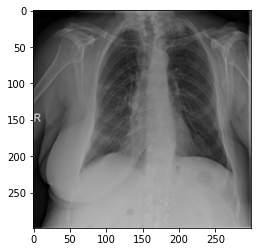

In [8]:
img = cv2.imread(os.path.join(list_images[0]))
plt.imshow(img)

# Extracting Features 


In [9]:
def extract_features(test_image):
  l = tf.keras.layers.Conv2D(32,(3,3),activation='relu', input_shape=(224,224,3),padding='same')(test_image)
  l = tf.keras.layers.MaxPool2D(2,2)(l)
  l = tf.keras.layers.Dropout(0.2)(l)
  l = tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(l)
  l = tf.keras.layers.MaxPool2D(2,2)(l)
  l = tf.keras.layers.Dropout(0.2)(l)
  l = tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(l)
  l = tf.keras.layers.MaxPool2D(2,2)(l)
  l = tf.keras.layers.Dropout(0.2)(l)
  l = tf.keras.layers.Flatten()(l)
  return asarray(l[0])

In [10]:
def expand_dims_image(image):
  return expand_dims(image,axis=0)

In [11]:
data = []
for img in list_images:
  img_ = cv2.imread(os.path.join(img))
  img_ = cv2.resize(img_, (224,224))
  img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
  img_ = img_/255
  me = mean(img_)
  img_ = img_ - me
  img_ = img_ / std(img_)
  data.append(img_)

In [12]:
data = asarray(data)

In [13]:
data.shape

(3616, 224, 224, 3)

In [14]:
data[0]

array([[[-1.76986134, -1.76986134, -1.76986134],
        [-1.76986134, -1.76986134, -1.76986134],
        [-1.76986134, -1.76986134, -1.76986134],
        ...,
        [-1.33070135, -1.33070135, -1.33070135],
        [-0.62804536, -0.62804536, -0.62804536],
        [ 0.07461064,  0.07461064,  0.07461064]],

       [[-2.23097934, -2.23097934, -2.23097934],
        [-2.23097934, -2.23097934, -2.23097934],
        [-2.23097934, -2.23097934, -2.23097934],
        ...,
        [-1.90160934, -1.90160934, -1.90160934],
        [-1.11112135, -1.11112135, -1.11112135],
        [-0.29867536, -0.29867536, -0.29867536]],

       [[-2.27489534, -2.27489534, -2.27489534],
        [-2.27489534, -2.27489534, -2.27489534],
        [-2.27489534, -2.27489534, -2.27489534],
        ...,
        [-1.94552534, -1.94552534, -1.94552534],
        [-1.15503735, -1.15503735, -1.15503735],
        [-0.38650736, -0.38650736, -0.38650736]],

       ...,

       [[-1.87965134, -1.87965134, -1.87965134],
        [-1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


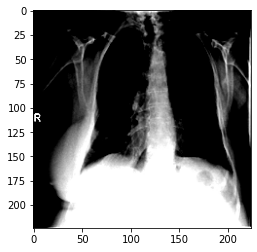

In [15]:
plt.imshow(data[0])

In [16]:
list_features = []
for img in data:
  img = expand_dims_image(img)
  features = extract_features(img)
  list_features.append(features)

In [17]:
list_features = asarray(list_features)

In [18]:
list_features.shape

(3616, 6272)

# Principal Component Analysis
Linear Dimensionality reduction using Singular Value Decomposition of data to project into lower dimensional space

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
result_pca = pca.fit_transform(list_features)

In [20]:
len(result_pca)

3616

# KMEANS Model 

In [28]:
def modelclustering(n_clusters, data):
  return KMeans(n_clusters=n_clusters, random_state = 0).fit(data)

In [36]:
def drawingmodel(result_pca, labels, labels_centered):
  plt.figure(figsize=(10,10))
  plt.scatter(result_pca[:,0], result_pca[:,1], c = labels, alpha=0.5,s=150)
  plt.scatter(labels_centered[:,0], labels_centered[:,1],marker='X', 
              s=200, linewidths=1.5, color='red', edgecolors="black", lw=1.5)
  plt.title("COVID-19 CLUSTERING")
  plt.xlabel("PCA 1")
  plt.ylabel("PCA 2")

# Clustering Chest X-ray COVID-19 Images Into 2 clusters

In [37]:
kmeans = modelclustering(2, list_features)
kmeans.labels_

array([1, 1, 0, ..., 1, 1, 0], dtype=int32)

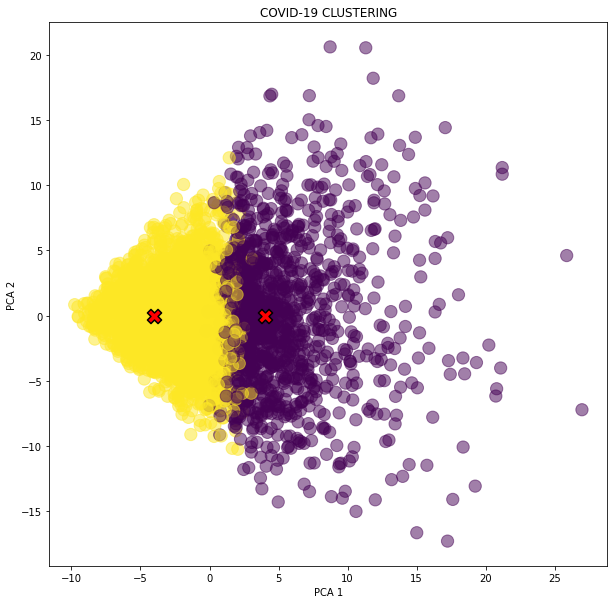

In [38]:
centroids = kmeans.cluster_centers_
labels_centered = pca.fit_transform(centroids)
drawingmodel(result_pca, kmeans.labels_, labels_centered)